In [183]:
import warnings

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import chi2_contingency, f_oneway, mannwhitneyu, pearsonr
from sklearn.feature_selection import f_regression

# Correcciones respecto de la función de JUANMA
    # No tenía control de errores
    # NO calculaba bien los missings y los unique values por la forma en que se llama a la función
def describe_df(df:pd.DataFrame) -> pd.DataFrame:
    """
    Generates a summary DataFrame that provides detailed information about 
    each column in the input DataFrame. The summary includes data types, 
    percentage of missing values, number of unique values, and the cardinality 
    of each column.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame to be described.

    Returns
    -------
    pandas.DataFrame or None
        A DataFrame with the following rows:
        - 'DATA_TYPE': Data type of each column.
        - 'MISSING (%)': Percentage of missing values in each column.
        - 'UNIQUE_VALUES': Number of unique values in each column.
        - 'CARDIN (%)': Cardinality percentage of each column (unique values / total rows).

        The returned DataFrame uses the column names from the input DataFrame.

    Raises
    ------
    TypeError
        If the input is not a pandas DataFrame.

    Notes
    -----
    - The function assumes that all columns in the input DataFrame are either 
      numeric, boolean, or categorical (objects).
    - The output DataFrame is transposed and rounded to two decimal places for 
      better readability.
    - The cardinality is a measure of the uniqueness of the data in a column 
      relative to the number of rows.

    Examples
    --------
    >>> import pandas as pd
    >>> df = pd.DataFrame({
    >>>     'A': [1, 2, 2, 3],
    >>>     'B': ['a', 'b', 'a', 'b'],
    >>>     'C': [True, False, True, True]
    >>> })
    >>> df_out = describe_dataframe(df)
    >>> print(df_out)
    
           DATA_TYPE  MISSING (%)  UNIQUE_VALUES  CARDIN (%)
    COL_N                                                  
    A          int64          0.0              3        75.0
    B         object          0.0              2        50.0
    C           bool          0.0              2        50.0
    """
    
    # Verificar que el argumento es un DataFrame
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Expected a pandas DataFrame")
    
    # Diccionario con las estadísticas
    data = {
        'COL_N': df.columns,
        'DATA_TYPE': df.dtypes.values,
        'MISSING (%)': df.isnull().mean().values * 100,
        'UNIQUE_VALUES': df.nunique().values,
        'CARDIN (%)': (df.nunique() / len(df)).values * 100
    }
    
    # Crear el DataFrame final y establecer la columna 'COL_N' como índice
    df_out = pd.DataFrame(data)
    df_out.set_index('COL_N', inplace=True)
    
    return df_out.round(2).T


# Correcciones respecto de la función de JUANMA
    # No tenía control de errores
    # No hacía falta el bucle for porque pandas ya aplica el cálculo a todas las columnas
    # SE podría COMPROBAR SI EL DATA FRAME TIENE COLUMNAS O ESTÁ VACÍO
def typify_variables(df:pd.DataFrame, umbral_categoria=10, umbral_continua=30.0) -> pd.DataFrame:
    """
    Suggests the type of each column in the input DataFrame based on cardinality and thresholds.

    This function takes a pandas DataFrame and provides a suggestion for each column's type 
    based on its cardinality relative to the provided thresholds.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame to be analyzed.

    umbral_categoria : int
        The threshold for distinguishing between categorical and numerical variables.
        If a column's cardinality is greater than or equal to this threshold, further checks are performed.

    umbral_continua : float
        The threshold for distinguishing between continuous and discrete numerical variables.
        If a column's cardinality percentage is greater than or equal to this threshold, the column is suggested 
        as "Numerica Continua". Otherwise, it is suggested as "Numerica Discreta".

    Returns
    -------
    pandas.DataFrame
        A DataFrame with two columns:
        - 'nombre_variable': The name of the column from the input DataFrame.
        - 'tipo_sugerido': Suggested type of the column, which can be "Binaria", "Categórica", 
          "Numerica Continua", or "Numerica Discreta".

    Raises
    ------
    TypeError
        If the input is not a pandas DataFrame or the thresholds are not of the correct type.

    Examples
    --------
    >>> import pandas as pd
    >>> df = pd.DataFrame({
    ...     'A': [1, 2, 2, None],
    ...     'B': ['x', 'y', 'x', 'x'],
    ...     'C': [10.0, 20.0, 20.0, 30.0]
    ... })
    >>> tipifica_variables(df, umbral_categoria=3, umbral_continua=50.0)
      nombre_variable          tipo_sugerido
    0                A       Binaria
    1                B       Categórica
    2                C  Numerica Continua
    """
    # Gestión de errores
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Expected a pandas DataFrame")
    
    if not isinstance(umbral_categoria, int) or not isinstance(umbral_continua, (int, float)):
        raise TypeError("Thresholds must be an integer and a float, respectively")

    # Calculate cardinality and percentage of unique values
    cardinality = df.nunique()
    cardinality_percentage = (cardinality / len(df)) * 100

    # Determine the suggested type for each column
    tipo_sugerido = []
    for col in df.columns:
        unique_count = cardinality[col]
        if unique_count == 2:
            tipo_sugerido.append("Binaria")
        elif unique_count < umbral_categoria:
            tipo_sugerido.append("Categórica")
        else:
            if cardinality_percentage[col] >= umbral_continua:
                tipo_sugerido.append("Numérica Continua")
            else:
                tipo_sugerido.append("Numérica Discreta")

    # Create the output DataFrame
    df_out = pd.DataFrame({
        'nombre_variable': df.columns,
        'tipo_sugerido': tipo_sugerido
        })

    return df_out


# Correcciones respecto de la función de LUIS
    # Añade un argumento a la función (umbral_card)
    # Faltaba comprobar cardinalidad
    # No retornaba None tras las "excepciones"
    # No hacía falta eliminar lista_num.remove(target_col) si se filtra en el primer if
    # Para que supere el test de pearson con una significancia de 1-p_value, p_value debe ser menor que el argumento que introduzcamos
    # Añadido el argumento pearson_results para mostrar el resultado del análisis
def get_features_num_regression(df:pd.DataFrame, target_col:str, umbral_corr:float, pvalue:float=None, umbral_card=10.0, pearson_results=False) -> list:
    """
    Obtiene las columnas numéricas de un DataFrame cuya correlación con la columna objetivo 
    supera un umbral especificado. Además, permite filtrar las columnas en función 
    de la significancia estadística de la correlación, mediante un valor-p opcional.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame que contiene los datos a analizar.

    target_col : str
        Nombre de la columna objetivo que se desea predecir; debe ser 
        una variable numérica continua o discreta con alta cardinalidad.

    umbral_corr : float
        Umbral de correlación absoluta para considerar una relación 
        significativa entre las columnas (debe estar comprendido entre 0 y 1).

    pvalue : float (opcional)
        Valor-p que determina el nivel de significancia para 
        filtrar las columnas. Si se proporciona, solo se incluirán 
        las columnas cuya correlación supere el umbral `umbral_corr` y cuyo 
        valor-p sea menor que `pvalue`, es decir, las que tengan una 
        significancia estadística mayor o igual a 1-p_value.
        Debe estar comprendido entre 0 y 1.
        
    umbral_card : float (opcional)
        Umbral para definir una alta cardinalidad en una variable numérica.
        Si la cardinalidad porcentual del target_col es superior o igual a este umbral, entonces se 
        considera que la columna tiene una alta cardinalidad. En otro caso, tiene una baja cardinalidad.
        
    pearson_results : bool (opcional)
        Si es `True`, imprime los resultados del test de Pearson para cada columna que
        cumpla los criterios de correlación y significancia. Los resultados incluyen el
        nombre de la columna, el valor de correlación y el p-valor correspondiente.

    Retorna:
    --------
    lista_num : list
        Lista de nombres de columnas numéricas que cumplen con los criterios establecidos.
        Si no hay columnas que cumplan los requisitos, se devuelve una lista vacía.
        Si algún argumento no es válido, se devuelve None.

    Excepciones:
    -----------
    La función imprime mensajes de error en los siguientes casos:
    - Si `df` no es un DataFrame.
    - Si `target_col` no es una columna del DataFrame.
    - Si `target_col` no es una variable numérica continua o es discreta con baja cardinalidad.
    - Si `umbral_corr` no es un número entre 0 y 1.
    - Si `pvalue` no es None y no es un número entre 0 y 1.

    En cualquiera de estos casos, la función retorna `None`.
    """
    # Comprobaciones iniciales de los argumentos
    if not _is_dataframe(df):
        return None
    
    if target_col not in df.columns:
        print(f"Error: {target_col} no es una columna del DataFrame.")
        return None
    
    if not pd.api.types.is_numeric_dtype(df[target_col]):
        print(f"Error: {target_col} no es una columna numérica.")
        return None
    
    if not isinstance(umbral_card, (int, float)):
        print(f"Error: {umbral_card} no es un valor válido para 'umbral_card'. Debe ser un float.")
        return None

    cardinality_percentage = (df[target_col].nunique() / len(df)) * 100
    if cardinality_percentage < umbral_card:
        print(f"Error: {target_col} es una columna numérica discreta, con baja cardinalidad.")
        return None

    if not isinstance(umbral_corr, (int, float)) or umbral_corr < 0 or umbral_corr > 1:
        print(f"Error: {umbral_corr} no es un valor válido para 'umbral_corr'. Debe estar entre 0 y 1.")
        return None
    
    if pvalue is not None and (not isinstance(pvalue, (int, float)) or pvalue < 0 or pvalue > 1):
        print(f"Error: {pvalue} no es un valor válido para 'pvalue'. Debe estar entre 0 y 1.")
        return None

    lista_num = []
    
    for columna in df.columns:
        if pd.api.types.is_numeric_dtype(df[columna]) and columna != target_col:
            resultado_test = pearsonr(df[columna], df[target_col])
            correlacion = resultado_test[0]
            p_valor = resultado_test[1]
            
            if abs(correlacion) > umbral_corr:
                # Confianza del 1-p_valor
                if pvalue is None or p_valor < pvalue:  
                    lista_num.append(columna)
                    if pearson_results:
                        print(f'columna={columna}, correlation={correlacion}, p_valor={p_valor}')
                    
    
    return lista_num


# Correcciones respecto de la función de LUIS
    # Añado valores por defecto en los argumentos (según indicaciones del enunciado)
    # Gestión de errores heredados desde get_features_num_regression
    # En vez de tener 4 veces el código de pintar, redefino las variables según el caso de uso y después voy al bucle de dibujar
    # La función devuelve las columnas numéricas (según indicaciones del enunciado)
def plot_features_num_regression(df:pd.DataFrame, target_col='', columns=[], umbral_corr=0.0, pvalue=None, umbral_card=10.0) -> list:
    """
    Visualiza las relaciones entre una columna objetivo y las columnas numéricas del DataFrame que cumplen con los criterios 
    de correlación y significancia especificados. Utiliza pairplots de Seaborn para mostrar las relaciones entre las 
    columnas seleccionadas.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame que contiene los datos a analizar.

    target_col : str, opcional
        Nombre de la columna objetivo que se desea predecir; debe ser una variable numérica continua o discreta 
        con alta cardinalidad.

    columns : list, opcional
        Lista de nombres de columnas numéricas a considerar para la visualización. Si se proporciona, solo se 
        visualizarán las columnas en esta lista que también cumplen con los criterios establecidos. Si se omite, 
        se utilizarán todas las columnas numéricas que cumplen con los criterios.

    umbral_corr : float, opcional
        Umbral de correlación absoluta para considerar una relación significativa entre las columnas (debe estar 
        comprendido entre 0 y 1). Solo se visualizarán las columnas cuya correlación con `target_col` sea mayor 
        que este umbral.

    pvalue : float, opcional
        Valor-p que determina el nivel de significancia para filtrar las columnas. Si se proporciona, solo se 
        incluirán las columnas cuya correlación supere el umbral y cuyo valor-p sea menor que `pvalue`, es decir, 
        las que tengan una significancia estadística mayor o igual a 1 - pvalue. Debe estar comprendido entre 0 y 1.

    umbral_card : float, opcional
        Umbral para definir una alta cardinalidad en una variable numérica. Si la cardinalidad porcentual del 
        `target_col` es superior o igual a este umbral, entonces se considera que la columna tiene una alta 
        cardinalidad. En otro caso, tiene una baja cardinalidad.

    Retorna:
    --------
    list
        Lista de nombres de columnas numéricas que cumplen con los criterios establecidos y que se han utilizado 
        para crear los pairplots. Si no hay columnas que cumplan los requisitos, se devuelve una lista vacía.

    Excepciones:
    -----------
    La función imprime mensajes de error en los siguientes casos:
    - Si `target_col` no está en el DataFrame.
    - Si ninguna columna cumple con los criterios de correlación y significancia.
    - Si ocurre algún problema al generar los pairplots.

    Ejemplo:
    --------
    >>> plot_features_num_regression(df, 'median_house_value', umbral_corr=0.1, pvalue=0.05, umbral_card=12.5)
    """

    # Obtener lista de features relevantes a través de get_features_num_regression 
    lista = get_features_num_regression(df, target_col, umbral_corr, pvalue, umbral_card)
    
    # Gestión errores heredados de get_features_num_regression()
    if lista is None:
        return None
    elif not lista: # [] != None != [columnas]
        print('Error: Ninguna columna cumple con los criterios de correlación y significancia.')
        return None
    
    # Si no se han especificado columnas, usar las obtenidas de get_features_num_regression
    if columns:
        numeric_columns = [col for col in columns if col in lista]
    if not columns:
        numeric_columns = lista
        
    # Dividir en grupos de 5 para los pairplots (1 columna objetivo + 4 columnas adicionales)
    for i in range(0, len(numeric_columns), 4):
        subset_cols = numeric_columns[i:i + 4]
        # Asegurarse que target_col siempre esté en cada subset
        if target_col not in subset_cols:
            subset_cols.insert(0, target_col)  
        sns.pairplot(df[subset_cols])
        plt.show()

    return numeric_columns


# Correcciones respecto de la función de CARLOS:
    # Añade argumentos de entrada a la función
    # Faltaba comprobar la cardinalidad
    # Cuando la columna es binaria no sabes si son (0, 1) o (True y False), así que generalizo el segundo if 
def get_features_cat_regression(df:pd.DataFrame, target_col:str, pvalue=0.05, umbral_categoria=10, umbral_card=10) -> list:
    """
    La función devuelve una lista con las columnas categóricas del dataframe cuyo test de relación 
    con la columna designada por 'target_col' supera el umbral de confianza estadística definido por 'pvalue'.
    
    La función realiza una Prueba U de Mann-Whitney si la variable categórica es binaria,
    o una prueba ANOVA (análisis de varianza) si la variable categórica tiene más de dos niveles.

    La función también realiza varias comprobaciones previas para asegurar que los argumentos de entrada son adecuados. 
    Si alguna condición no se cumple, la función retorna 'None' y muestra un mensaje explicativo.

    Parámetros
    ----------
    df : pd.DataFrame
        Dataframe que contiene los datos a analizar.

    target_col : str
        Nombre de la columna objetivo que se desea predecir; debe ser una variable numérica continua 
        o discreta con alta cardinalidad.

    pvalue : float (opcional)
        Umbral de significancia estadística para los tests de relación. Su valor por defecto es 0.05.

    umbral_categoria : int (opcional)
        Umbral para considerar una variable como categórica en función de su cardinalidad.
        Su valor por defecto es 10.

    umbral_card : int (opcional)
        Porcentaje mínimo de valores únicos en relación al tamaño del dataframe por encima del cual 
        una variable numérica se considera de alta cardinalidad. Su valor por defecto es 10.

    Retorna:
    lista_categoricas : list
        Lista de nombres de columnas categóricas que cumplen con los criterios establecidos.
        Si no hay columnas que cumplan los requisitos, se devuelve una lista vacía.
        Si las condiciones de entrada no se cumplen, se devuelve None.
    """

    # Comprobaciones
    if not _is_dataframe(df):
        return None
    
    if target_col not in df.columns:
        print("Error: La columna objetivo no existe en el DataFrame.")
        return None

    if not pd.api.types.is_numeric_dtype(df[target_col]):
        print("Error: La columna objetivo debe ser de tipo numérico.")
        return None

    if not (0 < pvalue <= 1):
        print("Error: El valor de pvalue debe estar entre 0 y 1.")
        return None

    # Comprobar si el target tiene alta cardinalidad
    cardinalidad_percent = (df[target_col].nunique() / df.shape[0]) * 100
    if cardinalidad_percent < umbral_card:
        print(f"Error: La columna objetivo no cumple con el umbral de alta cardinalidad ({umbral_card}%).")
        return None

    # Lista de columnas categóricas que cumplen los criterios
    lista_categoricas = []

    # Recorrer las columnas del DataFrame
    for col in df.columns:
        # Comprobar si la columna es categórica en función del umbral de cardinalidad
        if pd.api.types.is_categorical_dtype(df[col]) or df[col].nunique() <= umbral_categoria:
            
            # Si la columna es binaria, realizar Prueba-U de Mann-Whitney
            if df[col].nunique() == 2:
                a = df.loc[df[col] == df[col].unique()[0], target_col]
                b = df.loc[df[col] == df[col].unique()[1], target_col]
                u_stat, p_val = mannwhitneyu(a, b)
                
                if p_val <= pvalue:
                    lista_categoricas.append(col)

            # Si tiene más de dos categorías, realizar ANOVA
            else:
                grupos = [df[df[col] == nivel][target_col] for nivel in df[col].unique()]
                f_val, p_val = f_oneway(*grupos)
                
                if p_val <= pvalue:
                    lista_categoricas.append(col)
    
    return lista_categoricas


def plot_features_cat_regression(df:pd.DataFrame, target_col:str, columns = [], umbral_corr =0, pvalue=0.05,umbral_categoria=10,umbral_card=3) -> list:
    '''puede usar internamente get_features_cat_regression'''
     # Obtener lista de features relevantes a través de get_features_num_regression
    lista = get_features_cat_regression(df, target_col, pvalue, umbral_categoria, umbral_card)
    
    # Gestión errores heredados de get_features_num_regression()
    if lista is None:
        return None
    elif not lista: # [] != None != [columnas]
        print('Error: Ninguna columna cumple con los criterios de correlación y significancia.')
        return None
    
    # Si no se han especificado columnas, usar las obtenidas de get_features_num_regression
    if columns:
        numeric_columns = [col for col in columns if col in lista]
    if not columns:
        numeric_columns = lista
        
    # Dividir en grupos de 5 para los pairplots (1 columna objetivo + 4 columnas adicionales)
    filas_ploteo = math.ceil(len(numeric_columns)/5)

    # Imprimo como comprobación las filas que plotearé
    print(filas_ploteo)

    fig, axes = plt.subplots(filas_ploteo,5,figsize=(10,10))
    for i in range(filas_ploteo):
        subset_cols = numeric_columns[i:i + 4]

        # Asegurarse que target_col siempre esté en cada subset
        if target_col not in subset_cols:
            subset_cols.insert(0, target_col)

        # Pintamos cada fila de axes.    
        col_plot = 0 # Columna a pintar
        for col in subset_cols:  
            if (filas_ploteo == 1):
                sns.histplot(df,x=df[col],ax=axes[col_plot])
            else:
                sns.histplot(df,x=df[col],ax=axes[i,col_plot])
            
            print("pinto",col,"en",i,"-",col_plot)
            col_plot += 1
    fig.show()

    return numeric_columns


##########################################################################################
#      PRIVATE FUNCTIONS            PRIVATE FUNCTIONS            PRIVATE FUNCTIONS       #
##########################################################################################


def _is_dataframe(df) -> bool:
    """
    Verifica si el objeto proporcionado es un DataFrame de pandas.

    Parámetros:
    -----------
    df : cualquier tipo
        Objeto que se desea verificar si es un DataFrame de pandas.

    Retorna:
    --------
    bool:
        Retorna `True` si el objeto es un DataFrame de pandas, de lo contrario, 
        imprime un mensaje de error y retorna `False`.

    Ejemplo:
    --------
    >>> _is_dataframe(pd.DataFrame())
    True
    
    >>> _is_dataframe([1, 2, 3])
    Error: Expected a pandas DataFrame
    False
    """
    if not isinstance(df, pd.DataFrame):
        print("Error: Expected a pandas DataFrame")
        return False
    else:
        return True
    


##########################################################################################
#   OTHER USEFUL FUNCTIONS        OTHER USEFUL FUNCTIONS        OTHER USEFUL FUNCTIONS   #
##########################################################################################

def get_cardinality(df:pd.DataFrame, threshold_categorical=10, threshold_continuous=30) -> pd.DataFrame:
    '''
    Calculates and returns cardinality statistics for each column in a pandas DataFrame, 
    classifying the columns based on their cardinality.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame for which cardinality statistics will be computed.
    threshold_categorical : int, optional (default=10)
        The threshold used to classify columns as 'Categoric' or 'Numeric - Discrete'. 
        Columns with a number of unique values less than this threshold are classified as 'Categoric'.
    threshold_continuous : int, optional (default=30)
        The threshold percentage used to classify columns as 'Numeric - Continuous'. 
        Columns where the percentage of unique values exceeds this threshold are classified as 'Numeric - Continuous'.

    Returns
    -------
    pandas.DataFrame
        A DataFrame with the following columns:
        - 'Card': The number of unique values in each column.
        - '%_Card': The percentage of unique values relative to the total number of rows in each column.
        - 'NaN_Values': The number of missing (NaN) values in each column.
        - 'Type': The data type of each column.
        - 'Class': The classification of each column based on its cardinality.
    '''
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Expected a pandas DataFrame")
    
    print('pandas.DataFrame shape: ', df.shape)
    
    df_out = pd.DataFrame([df.nunique(), df.nunique()/len(df) * 100, df.isna().sum(), df.dtypes])
    df_out = df_out.T.rename(columns = {0: 'Card', 1: '%_Card', 2: 'NaN_Values', 3: 'Type'})
    
    df_out.loc[df_out['Card'] < threshold_categorical, 'Class'] = 'Categoric'    
    df_out.loc[df_out['Card'] == 2, 'Class'] = 'Binary'
    df_out.loc[df_out['Card'] >= threshold_categorical, 'Class'] ='Numeric - Discrete'
    df_out.loc[df_out['%_Card'] > threshold_continuous, 'Class'] = 'Numeric - Continuous'
    
    return df_out


In [184]:
df = pd.read_csv('./data/titanic.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sex          891 non-null    object 
 1   age          891 non-null    float64
 2   sibsp        891 non-null    int64  
 3   parch        891 non-null    int64  
 4   fare         891 non-null    float64
 5   class        891 non-null    object 
 6   who          891 non-null    object 
 7   adult_male   891 non-null    bool   
 8   embark_town  891 non-null    object 
 9   alive        891 non-null    object 
 10  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(2), object(5)
memory usage: 64.5+ KB


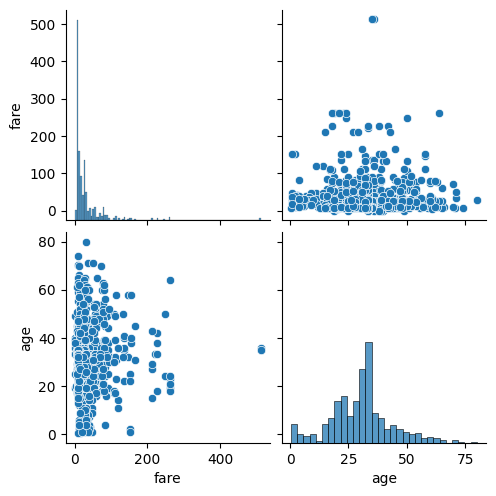

['age']

In [185]:
plot_features_num_regression(df, target_col='fare', columns=['age'], umbral_corr=0.0, pvalue=None, umbral_card=10.0)

1
pinto fare en 0 - 0
pinto sex en 0 - 1
pinto embark_town en 0 - 2
pinto sibsp en 0 - 3
pinto parch en 0 - 4


C:\Users\juanmanu.gomez\AppData\Local\Temp\ipykernel_17256\171797168.py:442: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[col]) or df[col].nunique() <= umbral_categoria:
C:\Users\juanmanu.gomez\AppData\Local\Temp\ipykernel_17256\171797168.py:506: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


['sex', 'embark_town', 'sibsp', 'parch']

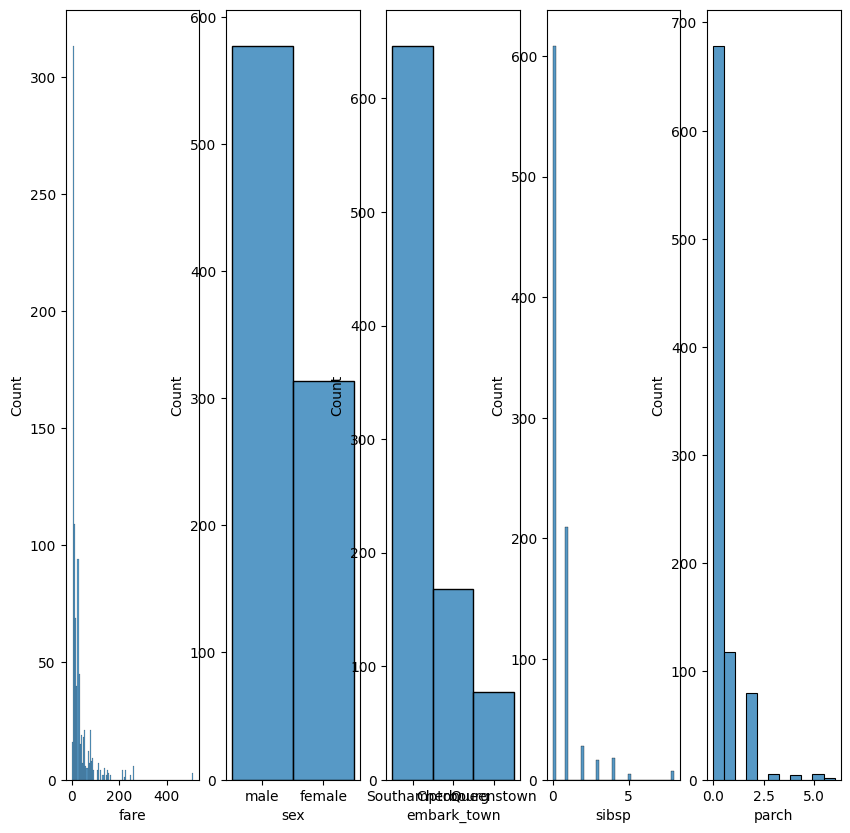

In [186]:
plot_features_cat_regression(df, "fare", ['sex','embark_town','sibsp','parch'], umbral_corr=0, pvalue=0.05, umbral_categoria=50, umbral_card=2)